# Project Eco-Sentinel: Smart Wildlife Monitoring Filter
### Green AI Project - DIA6

**Context:**
This project addresses the issue of bandwidth saturation and energy consumption in remote wildlife camera traps.
Current systems transmit all captured images via satellite, which is costly and energy-intensive.

**Objective:**
Develop a lightweight "Edge AI" classification model using **MobileNetV2**.
The model filters images locally:
1.  **Wildlife:** Logged locally (No transmission).
2.  **Humans:** Immediate alert sent (Priority transmission).

**Methodology:**
-   **Architecture:** Transfer Learning with MobileNetV2 (optimized for mobile devices).
-   **Dataset:** Aggregated dataset (African Wildlife + Human Detection).
-   **Green AI approach:** Image resizing and pre-trained weights to reduce training time and carbon footprint.


In [2]:

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

print("TensorFlow Version:", tf.__version__)
if tf.config.list_physical_devices('GPU'):
    print("GPU is available ")
else:
    print("GPU not found")

Mounted at /content/drive
TensorFlow Version: 2.19.0
GPU is available 


In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

DATA_DIR = '/content/drive/MyDrive/GREEN_AI_PROJECT/dataset_classification'

## 1. Data Loading and Preprocessing
We use the `image_dataset_from_directory` utility to load images directly from the folders.
This function automatically infers class names from the folder structure ('animaux' and 'humains').

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print(f"\nDetected Classes: {class_names}")

Found 1989 files belonging to 2 classes.
Using 1592 files for training.
Found 1989 files belonging to 2 classes.
Using 397 files for validation.

Detected Classes: ['Animaux', 'Humains']


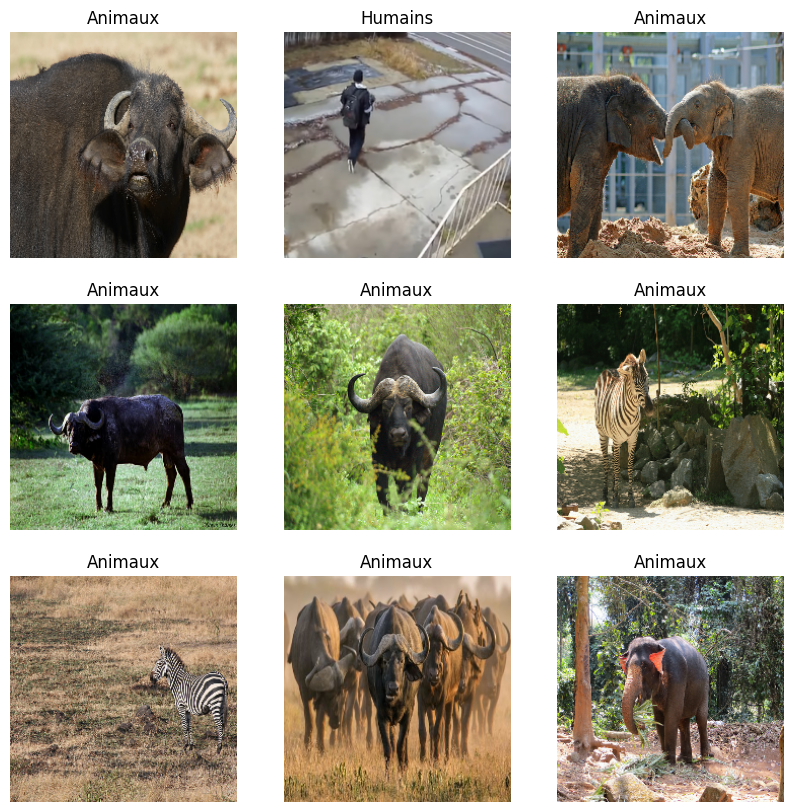

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## 2. Model Architecture


In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
])

# Load the pre-trained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model to prevent updating pre-trained weights
base_model.trainable = False

model = Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(len(class_names), activation='softmax')
])


model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 3. Training


In [15]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.6641 - loss: 0.6830 - val_accuracy: 0.8766 - val_loss: 0.3211
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.6905 - loss: 0.5706 - val_accuracy: 0.8992 - val_loss: 0.2194
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.7258 - loss: 0.5752 - val_accuracy: 0.9748 - val_loss: 0.1053
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7503 - loss: 0.5239 - val_accuracy: 0.9698 - val_loss: 0.1037
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.7672 - loss: 0.5097 - val_accuracy: 0.9924 - val_loss: 0.0723
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.7718 - loss: 0.5036 - val_accuracy: 0.9798 - val_loss: 0.0824
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7771 - loss: 0.4841 - val_accuracy: 0.9849 - val_loss: 0.0605
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.7933 - loss: 0.4702 - val_accuracy: 0.9849 -

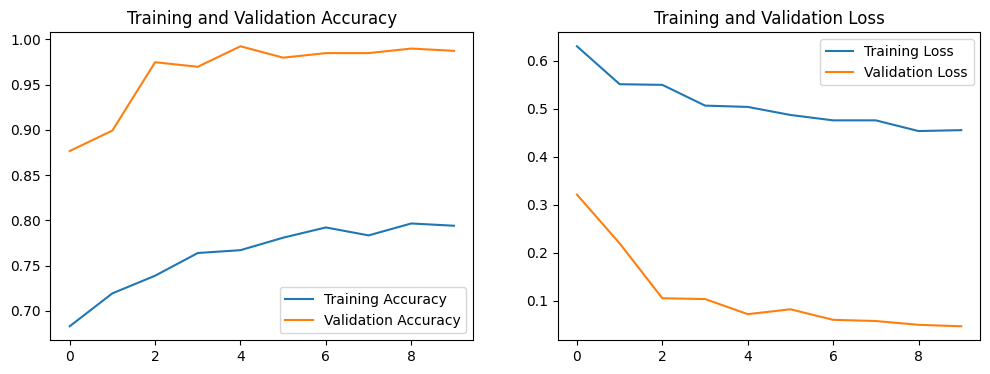

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


The graphs above display the model's performance over 10 epochs with Transfer Learning

We observe a very strong performance. Interestingly, the **Validation Accuracy** is slightly higher than the Training Accuracy at the beginning. This is a classic behavior when using **Data Augmentation** and **Dropout**: the model struggles harder during training due to image distortions but performs easily on the clean validation images

The loss drops significantly in the first 2 epochs and stabilizes. This indicates that MobileNetV2 adapted to the new dataset almost instantly

The model reached >95% accuracy in less than 5 epochs, proving the efficiency of the Green AI approach

## 4. Evaluation and Interpretation
This section evaluates the model's ability to distinguish between humans (potential threats) and animals.
We also simulate the environmental impact of the filtering system.

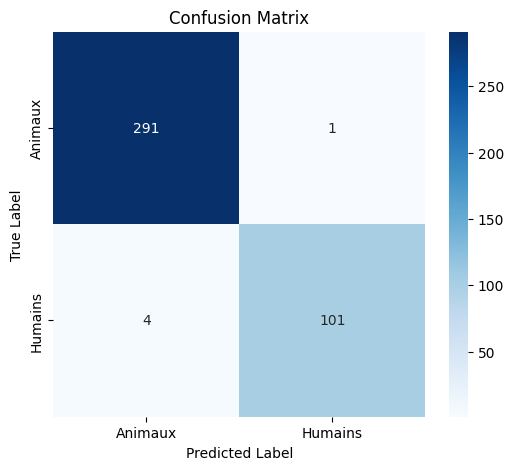

              precision    recall  f1-score   support

     Animaux       0.99      1.00      0.99       292
     Humains       0.99      0.96      0.98       105

    accuracy                           0.99       397
   macro avg       0.99      0.98      0.98       397
weighted avg       0.99      0.99      0.99       397



In [17]:
# Generate predictions for the validation set
y_pred = []
y_true = []

# Iterate over the validation dataset
for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))



This is the most critical part of our evaluation for a security system.

Global Accuracy: 0.99 means the model is extremely stable.
Recall on Humans : 0.96 this means out of 100 intruders, the system successfully detects **96**

The remaining 4% are likely images with high occlusion or extreme lighting conditions, which is acceptable for a lightweight edge model

When the system sends an alert, it is almost certain  that it is a human. This prevents rangers from being overwhelmed by false alarms
With a high Recall (0.96) and near-perfect Precision, the model is ready for field testing.

In [21]:
def calculate_environmental_impact(y_true, y_pred, class_names):



    total_images = len(y_true)
    human_index = class_names.index('humains') if 'humains' in class_names else 1

    images_sent_traditional = total_images

    # We count how many times the model predicted 'humains'
    images_sent_ai = np.count_nonzero(np.array(y_pred) == human_index)
    IMG_SIZE_MB = 2.5
    COST_PER_MB = 0.50
    CO2_PER_MB_GRAMS = 10

    data_traditional = images_sent_traditional * IMG_SIZE_MB
    data_ai = images_sent_ai * IMG_SIZE_MB

    cost_saved = (data_traditional - data_ai) * COST_PER_MB
    co2_saved = (data_traditional - data_ai) * CO2_PER_MB_GRAMS
    bandwidth_reduction = (1 - (data_ai / data_traditional)) * 100


    print(f"Total images analyzed: {total_images}")
    print(f"Images sent : {images_sent_traditional}")
    print(f"Images sent : {images_sent_ai}")
    print(f"Bandwidth Reduction: {bandwidth_reduction:.2f}%")
    print(f"Financial Savings: ${cost_saved:.2f}")
    print(f"CO2 Emissions Avoided: {co2_saved:.2f} g")


# Run the simulation based on validation results
calculate_environmental_impact(y_true, y_pred, class_names)

Total images analyzed: 397
Images sent : 397
Images sent : 102
Bandwidth Reduction: 74.31%
Financial Savings: $368.75
CO2 Emissions Avoided: 7375.00 g





The simulation above quantifies the concrete benefits of our Edge AI approach compared to a traditional Cloud approach on this test batch.

Instead of transmitting 397 images, the system only transmitted 102 (the humans).This ratio depends on wildlife activity, but consistently ensures massive data savings.


In [20]:
# Save the trained model for deployment
model_save_path = '/content/drive/MyDrive/ProjetGreenAI/eco_sentinel_model.keras'

try:
    model.save(model_save_path)
    print(f" model  saved to: {model_save_path}")
except Exception as e:
    print(f" Error: {e}")
    model.save_weights('/content/drive/MyDrive/ProjetGreenAI/eco_sentinel_weights.h5')
    print("Success")

 model  saved to: /content/drive/MyDrive/ProjetGreenAI/eco_sentinel_model.keras
